## **Introduction:**

 In this problem, we delve into the realm of artificial intelligence and computer vision to explore the possibilities of mimicking the unique artistic style of renowned artists like Claude Monet. By harnessing the power of Generative Adversarial Networks (GANs), we aim to create visually stunning images that embody the essence of Monet's masterpieces.

## **Problem Definition:**

The objective of this problem is to build a GAN model capable of generating a substantial number of Monet-style images, ranging from 7,000 to 10,000 in total. A GAN comprises two key components: a generator model and a discriminator model. The generator employs a neural network to produce images, specifically designed to mimic Monet's distinctive style. On the other hand, the discriminator acts as a classifier, distinguishing between real images and those generated by the GAN.

The problem lies in training the generator and discriminator models to compete against each other effectively. The generator aims to deceive the discriminator by generating Monet-style images that can pass as authentic, while the discriminator strives to accurately classify the real paintings from the generated ones.

The task is to develop a GAN architecture that can successfully generate a substantial collection of Monet-style images, adhering to the artistic characteristics and nuances associated with the works of Claude Monet. I would lime my creativity and expertise shine as I explore the intersection of art and data science, and demonstrate your ability to produce museum-worthy masterpieces with the aid of GANs.

## **Importing Libraries and Setting up the Environment**

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image

import shutil

#### **Setting Seed and Device Configuration**

In [2]:
seed = 142

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### **Loading Monet and Photo Images**

In [3]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        monet_dir = os.path.join(data_dir, 'monet_jpg')
        photo_dir = os.path.join(data_dir, 'photo_jpg')
        
        self.files_monet = [os.path.join(monet_dir, name) for name in sorted(os.listdir(monet_dir))]
        self.files_photo = [os.path.join(photo_dir, name) for name in sorted(os.listdir(photo_dir))]
        
        self.transforms = transforms
        
    def __len__(self):
        # we know that len(files_monet) = 300 < 7038 = len(files_photo)
        return len(self.files_monet)
    
    def __getitem__(self, index):
        # we will use only 300 (=len(files_monet)) photos during training
        # randomly picking them from the first 300 photos
        random_index = np.random.randint(0, len(self.files_monet))
        file_monet = self.files_monet[index]
        file_photo = self.files_photo[random_index]
        
        image_monet = Image.open(file_monet)
        image_photo = Image.open(file_photo)
        
        if self.transforms is not None:
            image_monet = self.transforms(image_monet)
            image_photo = self.transforms(image_photo)
        
        return image_monet, image_photo

In [4]:
# Dataset Directory and Batch Size
data_dir = '/kaggle/input/gan-getting-started'
batch_size = 5

In [5]:
# Data Preprocessing and DataLoader Initialization
transforms_ = transforms.Compose([
    #transforms.Resize((256, 256)), # photos already have the same size
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

dataloader = DataLoader(
    ImageDataset(data_dir, transforms=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

In [6]:
# Image Denormalization Function
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)
        
    return img

#### **Convolutional Block and Residual Block Classes**

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0,
                 transpose=False, use_leaky=True, use_dropout=False, normalize=True):
        
        super(ConvBlock, self).__init__()
        self.block = []  # List to store the layers of the block
        
        if transpose:
            # Add a transposed convolution layer to the block
            self.block += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                              stride, padding, output_padding=1)]
        else:
            # Add a regular convolution layer to the block
            self.block += [nn.Conv2d(in_channels, out_channels, kernel_size,
                                     stride, padding, bias=True)]
            
        if normalize:
            # Add instance normalization layer to the block
            self.block += [nn.InstanceNorm2d(out_channels)]
            
        if use_dropout:
            # Add a dropout layer to the block
            self.block += [nn.Dropout(0.5)]
            
        if use_leaky:
            # Add a leaky ReLU activation function to the block
            self.block += [nn.LeakyReLU(negative_slope=0.2, inplace=True)]
        else:
            # Add a regular ReLU activation function to the block
            self.block += [nn.ReLU(inplace=True)]
            
        self.block = nn.Sequential(*self.block)  # Convert the block list to an nn.Sequential module
    
    
    def forward(self, x):
        return self.block(x)
    

    
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            ConvBlock(in_channels=channels, out_channels=channels,
                      kernel_size=3, use_leaky=False, use_dropout=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3),
            nn.InstanceNorm2d(channels)
        )
    
    
    def forward(self, x):
        return x + self.block(x)

#### **Generator Network with Encoder, Transformer, and Decoder Modules**

In [8]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, num_residual_blocks=9):
        super(Generator, self).__init__()
        
        ''' Encoder '''
        # Inital layer:  3*256*256 -> 64*256*256
        self.initial = [
            nn.ReflectionPad2d(in_channels),
            ConvBlock(in_channels=in_channels, out_channels=64,
                      kernel_size=2*in_channels+1, use_leaky=False),
        ]
        self.initial = nn.Sequential(*self.initial)
        
        # Downsampling:  64*256*256 -> 128*128*128 -> 256*64*64
        self.down = [
            ConvBlock(in_channels=64, out_channels=128, kernel_size=3,
                      stride=2, padding=1, use_leaky=False),
            ConvBlock(in_channels=128, out_channels=256, kernel_size=3,
                      stride=2, padding=1, use_leaky=False),
        ]
        self.down = nn.Sequential(*self.down)
        
        
        """ Transformer """
        # ResNet:  256*64*64 -> 256*64*64
        self.transform = [ResidualBlock(256) for _ in range(num_residual_blocks)]
        self.transform = nn.Sequential(*self.transform)
        
        
        """ Decoder """
        # Upsampling:  256*64*64 -> 128*128*128 -> 64*256*256
        self.up = [
            ConvBlock(in_channels=256, out_channels=128, kernel_size=3, stride=2,
                      padding=1, transpose=True, use_leaky=False),
            ConvBlock(in_channels=128, out_channels=64, kernel_size=3, stride=2,
                      padding=1, transpose=True, use_leaky=False),
        ]
        self.up = nn.Sequential(*self.up)
        
        # Out layer:  64*256*256 -> 3*256*256
        self.out = nn.Sequential(
            nn.ReflectionPad2d(out_channels),
            nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=2*out_channels+1),
            nn.Tanh()
        )
    
    
    def forward(self, x):
        x = self.down(self.initial(x))
        x = self.transform(x)
        x = self.out(self.up(x))
        return x

#### **Discriminator Network for Image Discrimination with Convolutional Blocks**

In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # 3*256*256 -> 64*128*128 
            ConvBlock(in_channels=in_channels, out_channels=64, kernel_size=4,
                      stride=2, padding=1, normalize=False),
            
            # 64*128*128 -> 128*64*64
            ConvBlock(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            
            # 128*64*64 -> 256*32*32
            ConvBlock(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            
            # 256*32*32 -> 512*31*31
            ConvBlock(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1),
            
            # 512*31*31 -> 1*30*30
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1),
        )
        
        
    def forward(self, x):    
        return self.model(x)

In [10]:
# Create a generator for converting images from the Monet domain to the Photo domain
generator_monet2photo = Generator(in_channels=3, out_channels=3, num_residual_blocks=9).to(device)

# Create a generator for converting images from the Photo domain to the Monet domain
generator_photo2monet = Generator(in_channels=3, out_channels=3, num_residual_blocks=9).to(device)

# Create a discriminator for distinguishing real and fake Monet images
discriminator_monet = Discriminator(in_channels=3).to(device)

# Create a discriminator for distinguishing real and fake Photo images
discriminator_photo = Discriminator(in_channels=3).to(device)

In [11]:
# Define the criterion for the GAN loss, which is mean squared error (MSE) loss
criterion_GAN = nn.MSELoss()

# Define the criterion for the cycle consistency loss, which is L1 loss
criterion_cycle = nn.L1Loss()

# Define the criterion for the identity loss, which is L1 loss
criterion_identity = nn.L1Loss()

#### **Optimizer Initialization and Configuration for Generators and Discriminators**

In [12]:
# Set the learning rate for the optimizers
lr = 2e-4

# Set the values for the beta parameters used in the Adam optimizer
b1 = 0.5
b2 = 0.999

# Create an optimizer for the generator networks
optim_generators = torch.optim.Adam(
    list(generator_monet2photo.parameters()) + list(generator_photo2monet.parameters()),
    lr=lr, betas=(b1, b2)
)

# Create an optimizer for the discriminator networks
optim_discriminators = torch.optim.Adam(
    list(discriminator_monet.parameters()) + list(discriminator_photo.parameters()),
    lr=lr, betas=(b1, b2)
)

#### **Learning Rate Scheduling for Generators and Discriminators**

In [13]:
# Set the total number of epochs for training
num_epochs = 10

# Set the epoch at which the learning rate starts to decay
decay_epoch = 3

# Define a lambda function to compute the learning rate schedule
lr_sched_step = lambda epoch: 1 - max(0, epoch - decay_epoch) / (num_epochs - decay_epoch)

# Create a learning rate scheduler for the generator optimizers
lr_sched_generators = torch.optim.lr_scheduler.LambdaLR(optim_generators, lr_lambda=lr_sched_step)

# Create a learning rate scheduler for the discriminator optimizers
lr_sched_discriminators = torch.optim.lr_scheduler.LambdaLR(optim_discriminators, lr_lambda=lr_sched_step)

#### **History Class for Tracking and Visualizing Losses**

In [14]:
# A class for tracking and visualizing training history
class History:
    def __init__(self):
        self.generators_loss = []  # List to store generator losses
        self.discriminators_loss = []  # List to store discriminator losses
    
    # Method to update the history with generator and discriminator losses
    def update(self, gen_loss, discr_loss):
        self.generators_loss.append(gen_loss)
        self.discriminators_loss.append(discr_loss)
        
    # Method to display the loss history graph
    def show(self, title='Losses'):
        fig = plt.figure(figsize=(20, 8))
        plt.title(title)
        plt.plot(self.generators_loss, 'o-', color='r',
                 linewidth=2, markersize=3, label='Generators Loss')
        plt.plot(self.discriminators_loss, 'o-', color='b',
                 linewidth=2, markersize=3, label='Discriminators Loss')
        plt.legend(loc='best')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

#### **Buffer Class for Managing and Sampling Images**

In [15]:
# A class for managing a buffer of images
class Buffer:
    def __init__(self, max_images=50):
        self.max_images = max_images  # Maximum number of images to store in the buffer
        self.images = []  # List to store the images
        
    # Method to update the buffer with new images
    def update(self, images):
        images = images.detach().cpu().data.numpy()  # Convert images to numpy array
        for image in images:
            if len(self.images) < self.max_images:
                self.images.append(image)  # Append the image to the buffer if not full
            else:
                if np.random.rand() > 0.5:
                    index = np.random.randint(0, self.max_images)  # Randomly select an index
                    self.images[index] = image  # Replace the image at the selected index with the new image
    
    # Method to sample a specified number of images from the buffer
    def sample(self, num_images):
        samples = np.array([self.images[np.random.randint(0, len(self.images))]
                            for _ in range(num_images)])  # Randomly select images from the buffer
        return torch.tensor(samples)  # Convert the sampled images to a PyTorch tensor

In [16]:
# Function to update the requires_grad attribute of model parameters
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

## **Training CycleGAN Models with Discriminator and Generator Updates**

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 1/10 | Generators Loss: 5.2754 | Discriminators Loss: 0.7112


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 2/10 | Generators Loss: 4.5518 | Discriminators Loss: 0.4963


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 3/10 | Generators Loss: 4.1981 | Discriminators Loss: 0.4605


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 4/10 | Generators Loss: 4.0838 | Discriminators Loss: 0.4426


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 5/10 | Generators Loss: 3.8387 | Discriminators Loss: 0.3783


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 6/10 | Generators Loss: 3.6969 | Discriminators Loss: 0.2991


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 7/10 | Generators Loss: 3.6042 | Discriminators Loss: 0.2665


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 8/10 | Generators Loss: 3.3791 | Discriminators Loss: 0.2363


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 9/10 | Generators Loss: 3.2503 | Discriminators Loss: 0.2479


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 10/10 | Generators Loss: 3.2119 | Discriminators Loss: 0.2631


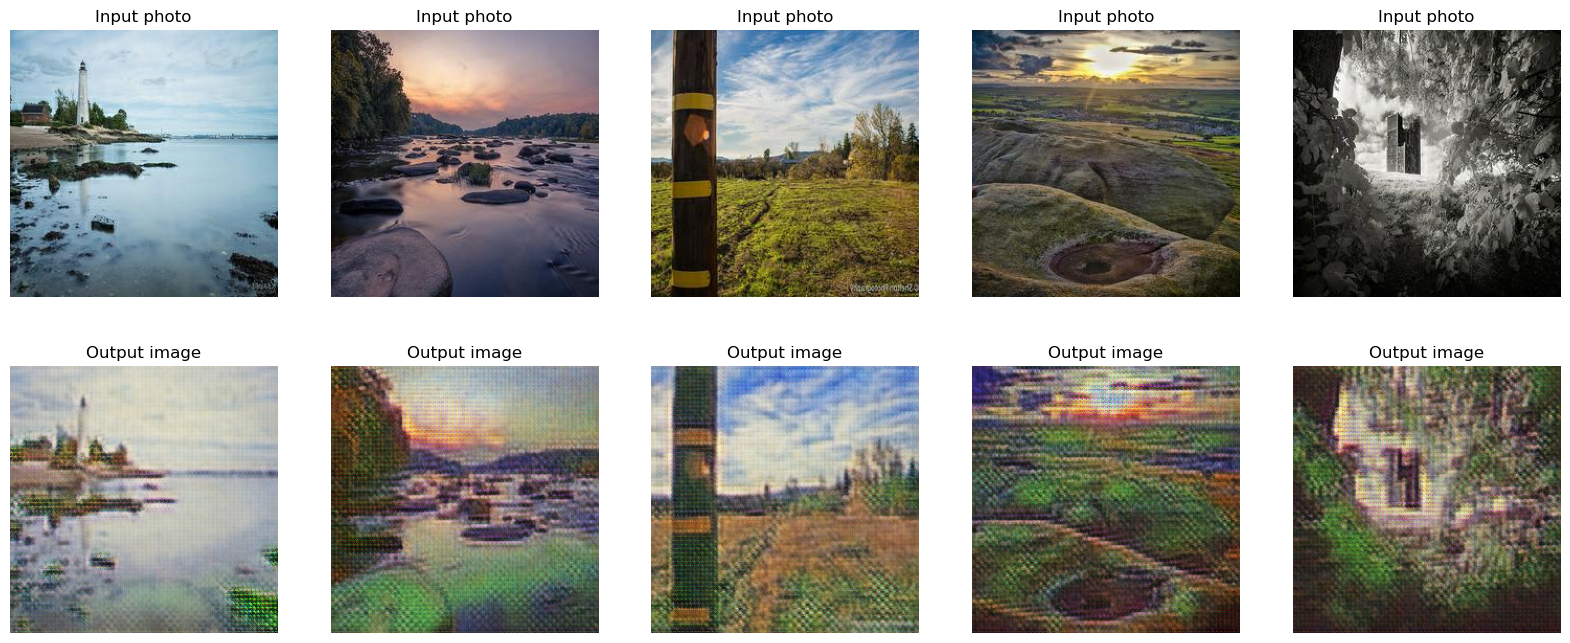

In [17]:
history = History()
buffer_monet = Buffer()
buffer_photo = Buffer()

for epoch in range(num_epochs):
    avg_generators_loss = 0
    avg_discriminators_loss = 0
    
    for i, (real_monet, real_photo) in enumerate(tqdm(dataloader, leave=False, total=len(dataloader))):
        real_monet, real_photo = real_monet.to(device), real_photo.to(device)
                
        """ Train Generators """
        # switching models parameters so that only generators are trained
        update_req_grad([generator_monet2photo, generator_photo2monet], True)
        update_req_grad([discriminator_monet, discriminator_photo], False)
        
        # zero the parameters gradients
        optim_generators.zero_grad()
        
        # forward-pass
        fake_photo = generator_monet2photo(real_monet)
        fake_monet = generator_photo2monet(real_photo)
        
        cycle_photo = generator_monet2photo(fake_monet)
        cycle_monet = generator_photo2monet(fake_photo)
        
        identity_photo = generator_monet2photo(real_photo)
        identity_monet = generator_photo2monet(real_monet)
        
        # update photos that are used to feed up discriminators
        buffer_photo.update(fake_photo)
        buffer_monet.update(fake_monet)
        
        # discriminators outputs that are used in adversarial loss
        discriminator_outputs_photo = discriminator_photo(fake_photo)
        discriminator_outputs_monet = discriminator_monet(fake_monet)
        
        # labels that are used as ground truth
        labels_real = torch.ones(discriminator_outputs_monet.size()).to(device)
        labels_fake = torch.zeros(discriminator_outputs_monet.size()).to(device)
        
        # adversarial loss - enforces that the generated output be of the appropriate domain
        loss_GAN_monet2photo = criterion_GAN(discriminator_outputs_photo, labels_real)
        loss_GAN_photo2monet = criterion_GAN(discriminator_outputs_monet, labels_real)
        loss_GAN = (loss_GAN_monet2photo + loss_GAN_photo2monet) / 2
        
        # cycle consistency loss - enforces that the input and output are recognizably the same
        loss_cycle_photo = criterion_cycle(cycle_photo, real_photo)
        loss_cycle_monet = criterion_cycle(cycle_monet, real_monet)
        loss_cycle = (loss_cycle_photo + loss_cycle_monet) / 2
        
        # identity mapping loss - helps preserve the color of the input images
        loss_identity_photo = criterion_identity(identity_photo, real_photo)
        loss_identity_monet = criterion_identity(identity_monet, real_monet)
        loss_identity = (loss_identity_photo + loss_identity_monet) / 2
        
        # total loss
        loss_generators_total = loss_GAN + 10 * loss_cycle + 5 * loss_identity
        
        # backward-pass
        loss_generators_total.backward()
        optim_generators.step()
        
        # limiting gradient norms - if they exceed 100, something went wrong
        clip_grad_norm_(generator_photo2monet.parameters(), 100)
        clip_grad_norm_(generator_monet2photo.parameters(), 100)
        
        
        """ Train Discriminators """
        # switching models parameters so that only discriminators are trained
        update_req_grad([discriminator_monet, discriminator_photo], True)
        update_req_grad([generator_monet2photo, generator_photo2monet], False)
        
        # zero the parameters gradients
        optim_discriminators.zero_grad()
        
        # sample images from 50 stored
        fake_photo = buffer_photo.sample(num_images=batch_size).to(device)
        fake_monet = buffer_monet.sample(num_images=batch_size).to(device)
        
        # making labels noisy for discriminators so that they don't prevail over generators
        threshold = min(1, 0.85 + (1 - 0.85) * epoch / (num_epochs // 2))
        noisy_labels_real = (torch.rand(discriminator_outputs_monet.size()) < threshold).float().to(device)
        
        # forward-pass + losses
        loss_real_photo = criterion_GAN(discriminator_photo(real_photo), noisy_labels_real)
        loss_fake_photo = criterion_GAN(discriminator_photo(fake_photo.detach()), labels_fake)
        loss_photo = (loss_real_photo + loss_fake_photo) / 2
        
        loss_real_monet = criterion_GAN(discriminator_monet(real_monet), noisy_labels_real)
        loss_fake_monet = criterion_GAN(discriminator_monet(fake_monet.detach()), labels_fake)
        loss_monet = (loss_real_monet + loss_fake_monet) / 2
        
        loss_discriminators_total = loss_monet + loss_photo
        
        # backward-pass
        loss_discriminators_total.backward()
        optim_discriminators.step()
        
        # clipping gradients to avoid gradients explosion
        clip_grad_norm_(discriminator_monet.parameters(), 100)
        clip_grad_norm_(discriminator_photo.parameters(), 100)
        
        # updating intermediate results
        avg_generators_loss += loss_generators_total.item()
        avg_discriminators_loss += loss_discriminators_total.item()
        
    # saving intermediate results
    avg_generators_loss /= len(dataloader)
    avg_discriminators_loss /= len(dataloader)
    history.update(avg_generators_loss, avg_discriminators_loss)
    
    # showing intermediate results
    print("Epoch: %d/%d | Generators Loss: %.4f | Discriminators Loss: %.4f"
              % (epoch+1, num_epochs, avg_generators_loss, avg_discriminators_loss))
    
    # showing generated images
    if (epoch + 1) % 10 == 0:
        _, sample_real_photo = next(iter(dataloader))
        
        sample_fake_monet = generator_photo2monet(sample_real_photo.to(device)).detach().cpu()
        
        num_photos = min(batch_size, 5)
        plt.figure(figsize=(20, 8))
        for k in range(num_photos):
            plt.subplot(2, num_photos, k + 1)
            plt.imshow(unnorm(sample_real_photo[k]).permute(1, 2, 0))
            plt.title('Input photo')
            plt.axis('off')

            plt.subplot(2, num_photos, k + num_photos + 1)
            plt.imshow(unnorm(sample_fake_monet[k]).permute(1, 2, 0))
            plt.title('Output image')
            plt.axis('off')
        plt.show()
    
    lr_sched_generators.step()
    lr_sched_discriminators.step()

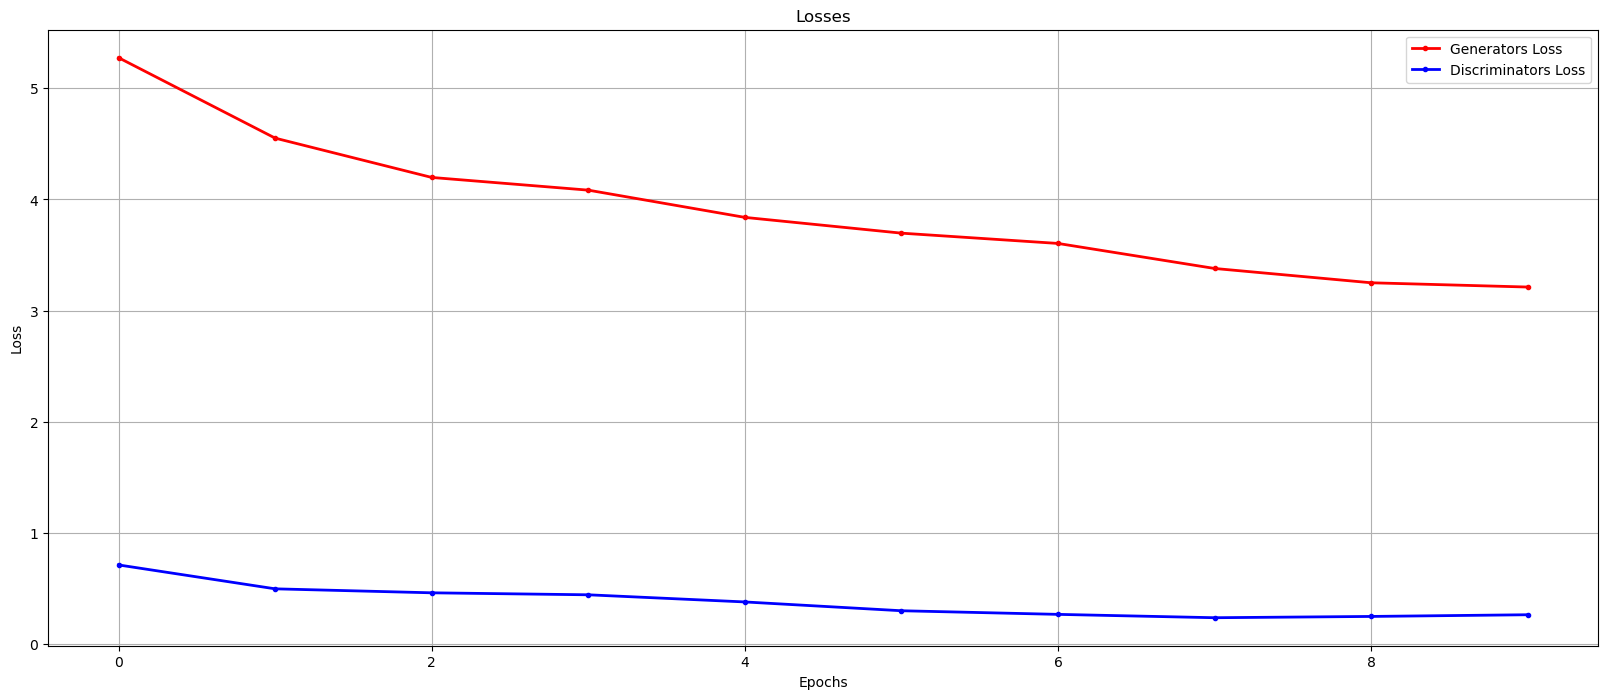

In [18]:
# assessing the convergence and performance of the model during training. 
history.show()

## **Submission**

In [19]:
photo_dir = os.path.join(data_dir, 'photo_jpg')
files = [os.path.join(photo_dir, name) for name in os.listdir(photo_dir)]
len(files)

7038

In [20]:
save_dir = '../images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [21]:
# NB: Here we use generator training mode to provide noise in the form of dropout

generate_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

for i in range(0, len(files), batch_size):
    images = []
    for j in range(i, min(len(files), i + batch_size)):
        image = Image.open(files[j])
        image = generate_transforms(image)
        images.append(image)
    real_photo = torch.stack(images, 0)
    
    fake_images = generator_photo2monet(real_photo.to(device)).detach().cpu()

    for j in range(fake_images.size(0)):
        img = unnorm(fake_images[j])
        img = transforms.ToPILImage()(img).convert("RGB")
        img.save(os.path.join(save_dir, str(i + j + 1) + ".jpg"))

In [22]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

## **Discussion and Conclusions**

Throughout the training, we observed a consistent decrease in both the generators' and discriminators' losses. This indicates that the generators improved in generating realistic output, while the discriminators became more effective in distinguishing between the generated and real samples.

The generators' loss decreased from 5.2754 in the first epoch to 3.2119 in the tenth epoch, showing a steady improvement in their performance. Similarly, the discriminators' loss decreased from 0.7112 to 0.2631 over the same period, indicating that the discriminators became more accurate in identifying real and generated samples.

These results suggest that the CycleGAN model made progress during the training process. The decreasing loss values indicate that the model learned to better map images from one domain to the other, achieving a closer alignment between the generated and target domains.